# Install Dependencies
This runs a pip install using the requirements.txt file that installs the dependencies for this notebook. Remove the # when first running this notebook on your machine. Afterward you can add it again.


In [44]:
#!pip install -r requirements.txt

# Imports


In [45]:
import numpy as np
import pandas as pd
import psycopg2
from psycopg2 import sql
import os
import requests
from decimal import Decimal
import concurrent.futures
import matplotlib.pyplot as plt
import os.path
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor


# User Settings

- years: An array of year Numbers that we want to download
- stationsFilePath: the path where the stations data is stored and located
- modifiedStationsFilePath: the path where the modified stations data is stored
- downloadCSVFilePath: where the csv.gz files from the ncei file server should be saved
- modifiedCSVFilePath: where the modified csv files should be saved
- dbname: the name of the database you want to connect to
- dbuser: the user that you want to connect with to the database
- dbpassword: the password for the user

In [46]:
years_in_db = [1950, 1951, 1952, 1953, 1954, 2010, 2011, 2012, 2013, 2014]
stationsFilePath = "./data/stations/"
modifiedStationsFilePath = "./data/stations/modifiedStations/"
downloadCSVFilePath = "./data/NCEI/ghcn/daily/"
modifiedCSVFilePath = "./data/NCEI/modified/daily/"
dbname = "NCEIDatabase"
dbuser = "ESDP"
dbpassword = "esdp1"
debug_messages = False


# Docker Setup

remember to execute the command `docker-compose up --build` if it's the first time running this file (or you changed the dbname, dbuser, dbpassword variables) and `docker-compose up` when have build the docker container previously

In [47]:
#httpsLink = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/"
#possible_years = np.arange(1949, 2020, 1)
host = "localhost"
port = "5432"

#this defines the names of the columns in the postgresql database
stationCols = ["id", "latitude", "longitude", "elevation", "state", "name", "gsn_flag", "hcn_crn_flag", "wmo_id"]
weatherCols = ["id", "stationcode", "datelabel", "param", "value", "mflag", "qflag", "sflag", "time"]


# Function Definitions for reusability

In [48]:
## These are the functions that establish the connection to the database and can be used to load the modified data into the database

def connect_to_db(db_name="mydatabase", db_user="myuser", db_password="mypassword", db_host="localhost",
                  db_port="5432"):
    """
    This creates a connection to an existing posgresql database using the provided parameteers
    
    :param db_name: the name of the database
    :param db_user: the user that you want to connect with
    :param db_password: the password of the user
    :param db_host: the host of the database
    :param db_port: the port of the database
    :return: connection, cursor if connection is successful
    """

    try:
        connection = psycopg2.connect(
            dbname=db_name,
            user=db_user,
            password=db_password,
            host=db_host,  # Connect to the host where Docker is running
            port=db_port
        )
        cursor = connection.cursor()

        if debug_messages:
            print(f"Connected to database {db_name} with user {db_user} with password {db_password}")

        return connection, cursor

    except Exception as error:
        print(f"Error: {error}")

    return


## Multi-Thread Versuche

In [49]:
## These are the Functions to download the data from the website and convert them
def download_stations(file_path_dest="./data/stations/"):
    """
    This function downloads the stations information (readme and ghcnd-stations.txt file) from the NCEI website and saves it in the specified directory
    
    :param file_path_dest: directory where the stations information will be saved
    :return: 
    """
    url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
    response = requests.get(url)
    if response.ok:
        filename = url.rsplit('/', 1)[1]
        print(f"data downloaded. Will be saved as {filename} in {file_path_dest}")
        os.makedirs(file_path_dest, exist_ok=True)
        with open(f"{file_path_dest}{filename}", "wb") as f:
            f.write(response.content)
    else:
        print("An error occured while trying to retrieve the data from the internet.")

    url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/readme.txt"
    response = requests.get(url)
    if response.ok:
        filename = url.rsplit('/', 1)[1]
        print(f"data downloaded. Will be saved as {filename} in {file_path_dest}")
        os.makedirs(file_path_dest, exist_ok=True)
        with open(f"{file_path_dest}{filename}", "wb") as f:
            f.write(response.content)
    else:
        print("An error occured while trying to retrieve the data from the internet.")

    print("Data downloaded and saved in", file_path_dest)
    return


def convert_stations(file_path="./data/stations/", file_path_dest="./data/modifiedStations/"):
    """
    This converts the ghcnd-stations.txt file to a csv file that we can load into the database
    
    :param file_path: The file path where the original ghcnd-stations.txt file is located
    :param file_path_dest: The path where the modified station file should be saved
    :return: 
    """

    # two helper functions
    def conv_str(x):
        return str(x)

    def conv_float(x):
        return float(x)

    # we get this information from the readme.txt file
    column_specs = [
        (0, 11),  # ID
        (12, 20),  # LATITUDE
        (21, 30),  # LONGITUDE
        (31, 37),  # ELEVATION
        (38, 40),  # STATE
        (41, 71),  # NAME
        (72, 75),  # GSN FLAG
        (76, 79),  # HCN/CRN FLAG
        (80, 85)  # WMO ID
    ]
    column_names = [
        'ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'STATE', 'NAME',
        'GSN FLAG', 'HCN/CRN FLAG', 'WMO ID'
    ]

    col_conv = {'ID': conv_str,
                'LATITUDE': conv_float,
                'LONGITUDE': conv_float,
                'ELEVATION': conv_float,
                'STATE': conv_str,
                'NAME': conv_str,
                'GSN FLAG': conv_str,
                'HCN/CRN FLAG': conv_str,
                'WMO ID': conv_str,
                }

    path_to_file = f"{file_path}ghcnd-stations.txt"
    df = pd.read_fwf(path_to_file, colspecs=column_specs, names=column_names, converters=col_conv)
    rename_columns = {
        'ID': 'code',
        'LATITUDE': 'lat',
        'LONGITUDE': 'lon',
        'ELEVATION': 'elevation',
        'STATE': 'state',
        'NAME': 'name',
        'GSN FLAG': 'flag1',
        'HCN/CRN FLAG': 'flag2',
        'WMO ID': 'wmo_id'
    }

    df.rename(columns=rename_columns, inplace=True)

    df['wmo_id'] = df['wmo_id'].astype(str)
    df.replace(['None', 'nan'], np.nan, inplace=True)
    df = df.fillna('')

    os.makedirs(file_path_dest, exist_ok=True)
    df.to_csv(f"{file_path_dest}/modified_stations.csv", index=False)
    print(f"saved the modified stations file to {file_path_dest}/modified_stations.csv")
    return


def download_year(year, file_path):
    url = f"https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/{year}.csv.gz"
    filename = url.rsplit('/', 1)[1]

    if os.path.isfile(f"{file_path}{filename}"):
        print(f"Already downloaded data for year {year}....")
        return

    print(f"...Downloading data from year {year}....")
    response = requests.get(url)
    if response.ok:
        print(f"Data downloaded. Will be saved as {filename}")
        directory_path = file_path
        os.makedirs(directory_path, exist_ok=True)
        with open(f"{file_path}{filename}", "wb") as f:
            f.write(response.content)
    else:
        print(f"An error occurred while trying to retrieve the data for year {year}.")
    print(f"Data from year {year} downloaded and saved.")

def download_years(array_of_years=None, file_path="./data/climate/script", multi_thread=False, num_threads=4):
    """
    This function downloads the specified years from the NCEI website and saves them in a csv file in the specified directory
    
    :param array_of_years: an array of years to download
    :param file_path: the directory to save the csv files
    :param multi_thread: boolean to enable multithreading
    :param num_threads: number of threads to use in multithreading mode
    :return: 
    """

    if array_of_years is None:
        array_of_years = [1994]

    if not multi_thread:
        for year in array_of_years:
            download_year(year, file_path)
    else:
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = [executor.submit(download_year, year, file_path) for year in array_of_years]
            for future in futures:
                try:
                    future.result()
                except Exception as e:
                    print(f"An error occurred: {e}")

    return

def process_year(year, file_path, file_path_dest, columns, scaling_factors):
    try:
        print(f"...Year {year} processing...")
        if os.path.isfile(f"{file_path_dest}/modified_{year}.csv"):
            print(f"Already exported data for year {year}....")
            return

        print(f"Loading data from year {year}")
        file_path_source = f"{file_path}{year}.csv.gz"
        df = pd.read_csv(file_path_source, names=columns, compression="gzip")
        print(f"Data from year {year} loaded.")

        # Convert time to int
        df['time'] = df['time'].fillna(1200)
        df['time'] = df['time'].apply(lambda x: int(Decimal(x)))
        # Convert values to float
        df = df.astype({"value": "float32"})

        # Cleanse dataset: keep only the parameters of interest, i.e. TMIN, TMAX, PRCP, SNOW
        keep = ["TMIN", "TMAX", "PRCP", "SNOW"]
        df = df[df["param"].isin(keep)]

        for k, v in scaling_factors.items():
            df.loc[df["param"] == k, "value"] *= v

        df = df.fillna('')

        os.makedirs(file_path_dest, exist_ok=True)
        df.to_csv(f"{file_path_dest}/modified_{year}.csv", index=True, header=False)
        print(f"Export of year {year} finished.")

    except Exception as error:
        print(f"Error: {error}")

def export_downloaded_years(array_of_years=None, file_path='./data/NCEI/ghcn/daily/',
                            file_path_dest="./data/NCEI/modified/daily/", multi_thread=False, num_threads=4):
    """
    This imports the specified years from the specified source path modifies it and exports them as a csv file in the specified destination directory
    
    :param array_of_years: the years to load and modify
    :param file_path: the directory where the source csv.gz files can be found
    :param file_path_dest: the directory where the modified csv files should be saved
    :param multi_thread: boolean to enable multithreading
    :param num_threads: number of threads to use in multithreading mode
    :return: 
    """
    if array_of_years is None:
        array_of_years = [1994]
    columns = ["stationcode", "datelabel", "param", "value", "mflag", "qflag", "sflag", "time"]
    scaling_factors = {"TMIN": 0.1, "TMAX": 0.1, "PRCP": 0.1}

    if not multi_thread:
        for year in array_of_years:
            process_year(year, file_path, file_path_dest, columns, scaling_factors)
    else:
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = [executor.submit(process_year, year, file_path, file_path_dest, columns, scaling_factors) for year in array_of_years]
            for future in futures:
                try:
                    future.result()
                except Exception as e:
                    print(f"An error occurred: {e}")

    return

In [50]:
def split_csv_file(file_path, lines_per_chunk):
    file_base, file_ext = os.path.splitext(file_path)
    with open(file_path, 'r') as f:
        header = f.readline()
        chunk_number = 0
        chunk_lines = []
        for i, line in enumerate(f):
            chunk_lines.append(line)
            if (i + 1) % lines_per_chunk == 0:
                chunk_file_path = f"{file_base}_chunk{chunk_number}{file_ext}"
                with open(chunk_file_path, 'w') as chunk_file:
                    chunk_file.write(header)
                    chunk_file.writelines(chunk_lines)
                chunk_lines = []
                chunk_number += 1
        # Write remaining lines to the last chunk
        if chunk_lines:
            chunk_file_path = f"{file_base}_chunk{chunk_number}{file_ext}"
            with open(chunk_file_path, 'w') as chunk_file:
                chunk_file.write(header)
                chunk_file.writelines(chunk_lines)
    return [f"{file_base}_chunk{chunk_number}{file_ext}" for chunk_number in range(chunk_number + 1)]


def run_parallel_inserts(file_paths, table_name, columns, max_workers=4):
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(insert_copy, file_path, table_name, columns) for file_path in file_paths]
        for future in concurrent.futures.as_completed(futures):
            try:
                future.result()
            except Exception as e:
                print(f"An error occurred: {e}")

In [51]:
def split_csv_file(self, file_path, num_chunks):
    """
    This splits a file into a specified number of chunks. Each chunk has the same size

    :param file_path: The Path to the file to be split
    :param num_chunks: the number of chunks
    :return: returns an array of file paths to the chunks
    """

    with open(file_path, 'r') as file:
        header = file.readline()
        lines = file.readlines()

    print(f"Total Number of lines: {len(lines)}")
    lines_per_chunk = int(np.ceil(len(lines) / num_chunks))
    print(f"Chunk size is {lines_per_chunk}")

    print(f"Splitting {file_path} into {num_chunks} chunks of size {lines_per_chunk}.")

    file_base, file_ext = os.path.splitext(file_path)

    with open(file_path, 'r') as f:
        header = f.readline()
        chunk_number = 0
        chunk_lines = []
        for i, line in enumerate(f):
            chunk_lines.append(line)
            if (i + 1) % lines_per_chunk == 0:
                print(
                    f"Writing chunk {chunk_number} file to {file_base}_chunk{chunk_number}{file_ext} with size {len(chunk_lines)}")
                chunk_file_path = f"{file_base}_chunk{chunk_number}{file_ext}"
                with open(chunk_file_path, 'w') as chunk_file:
                    chunk_file.write(header)
                    chunk_file.writelines(chunk_lines)
                chunk_lines = []
                chunk_number += 1
        # Write remaining lines to the last chunk
        if chunk_lines:
            print(
                f"Writing chunk {chunk_number} file to {file_base}_chunk{chunk_number}{file_ext} with size {len(chunk_lines)}")
            chunk_file_path = f"{file_base}_chunk{chunk_number}{file_ext}"
            with open(chunk_file_path, 'w') as chunk_file:
                chunk_file.write(header)
                chunk_file.writelines(chunk_lines)
    return [f"{file_base}_chunk{chunk_number}{file_ext}" for chunk_number in range(chunk_number + 1)]

def multi_threaded_insert(self, file_path, table_name=None, columns=None, num_threads=4):
    """
    This is a multi_threaded insert function. It Takes a file as input, and splits it into a number of chunks
    specified by num_threads. It then starts a thread for each chunk and inserts the data into the specified table.
    When a thread finishes it also deletes the chunk file.

    :param file_path: path to the file to be inserted
    :param table_name: name of the table to be inserted into
    :param columns: the columns of the table
    :param num_threads: number of chunks and threads to use
    :return:
    """
    if columns is None:
        columns = []

    if table_name is None:
        print(f"Error: table_name must be provided")
        return

    # this splits the file into equal sized chunks. That way one thread shouldn't finish that much earlier
    # than another, and we use resources efficiently
    chunks = split_csv_file(file_path, num_threads)

    def insert_chunk(chunk_file):
        # we use a specifically defined method so that it deletes the chunk
        # file at the end to clean up the data folder
        print(f'Thread started for chunk: {chunk_file}')
        try:
            connection, cursor = connect_to_db()
            copy_command = sql.SQL("""
                COPY {table} ({columns}) FROM STDIN WITH CSV HEADER
            """).format(
                table=sql.Identifier(table_name),
                columns=sql.SQL(',').join(map(sql.Identifier, columns))
            )

            with open(chunk_file, 'r') as chunk:
                # this adds the chunk to the database using copy statement
                cursor.copy_expert(copy_command, chunk)
            connection.commit()
            print(f'Thread for chunk {chunk_file} completed.')
        except Exception as error:
            print(f"Error in thread: {error}")
            if connection:
                connection.rollback()
        finally:
            if cursor:
                cursor.close()
            if connection:
                connection.close()
            # this removes the chunk file after we are finished with it
            os.remove(chunk_file)

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(insert_chunk, chunk_file) for chunk_file in chunks]
        for future in futures:
            try:
                future.result()
            except Exception as e:
                print(f"An error occurred: {e}")

    count_rows(table_name)
    print(f"Multi-threaded insert completed for {table_name}.")

    return

## Task / Use Case

We want to compare different parameters for the years 1950-1955 and 2010-2015.  
We have the parameters TMIN, TMAX, PRCP etc.

1. Create lineplot for a daterange (one year or days of different years)
2. Boxplot
3. Geographic plot

In [52]:
years = [1950, 1951, 1952, 1953, 1954, 2010, 2011, 2012, 2013, 2014]

### TASK 1: Get data between range

In [53]:
def get_data_between_dates_one_year(year, startdate, enddate, parameters, stations, columns):
    """
    Retrieves data from the SQL database.
        
    :param years: 
    :param columns: 
    :param condition: 

    :return: 
    """
    # connect to database
    connection, cursor = connect_to_db(dbname, dbuser, dbpassword, host, port)
    if debug_messages:
        print("Connection established.")
    
    try:
        table_name = f'Climate{year}'

        stations_sql_list = ",".join([f"'{station}'" for station in stations])
        parameters_sql_list = ",".join([f"'{parameter}'" for parameter in parameters])

        # Construct the COUNT query using psycopg2.sql
        command = sql.SQL('''
                SELECT {columns} 
                FROM {table}
                WHERE stationcode IN ({stations}) AND 
                        param IN ({parameters})
                ORDER BY datelabel                
        ''').format(
            columns=sql.SQL(', ').join(map(sql.Identifier, columns)),
            table=sql.Identifier(table_name),
            stations=sql.SQL(stations_sql_list),
            parameters=sql.SQL(parameters_sql_list),
        )

        if debug_messages:
            print(command.as_string(cursor.connection))
        # Execute the SELECT query
        cursor.execute(command)
        result = cursor.fetchall()

        data = pd.DataFrame(result, columns=columns)
            
        # Print the result specifications
        if debug_messages:
            print(f"The requested query returned {len(data)} results.")

        return data

    except Exception as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()

    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

def get_data_between_dates(startdate, enddate, parameters, stations, columns):
    """
    Retrieves data from the SQL database.
    
    :return: 
    """
    try:
        start_year = startdate[:4]
        end_year = enddate[:4]
        
        if start_year == end_year & check_year(year):
            df = get_data_between_dates_one_year(start_year, startdate, enddate, parameters, stations, columns)
        else: 
            years_to_process = np.arange(int(start_year), int(end_year)+1, 1)

            filtered_years = [year for year in years_to_process if check_year(year)]

            df = pd.DataFrame()
            for year in filtered_years:
                new = get_data_between_dates_one_year(year, startdate, enddate, parameters, stations, columns)
                df = pd.concat([df, new])

        return df

    except Exception as error:
        print(f"Error: {error}")
        
    finally:
        pass

def get_data_yearly(years, parameters, stations, columns):
    """
    Retrieves data from the SQL database.
    
    :return: 
    """
    try:

        filtered_years = [year for year in years if check_year(year)]

        df = pd.DataFrame()
        for year in filtered_years:
            new = get_data_between_dates_one_year(year, f"{year}-01-01", f"{year}-12-31", parameters, stations, columns)
            df = pd.concat([df, new])

        return df

    except Exception as error:
        print(f"Error: {error}")
        
    finally:
        pass

In [54]:
def is_valid_year(year):
    if(year in years_in_db):
        return True
    else:
        return False
    
def is_year_in_db(year):
    connection, cursor = connect_to_db(dbname, dbuser, dbpassword, host, port)
    if debug_messages:
        print("Connection established.")
    
    try:
        table_name = f'Climate{year}'

        # Construct the COUNT query using psycopg2.sql
        command = sql.SQL('''
                SELECT COUNT(*)
                FROM {table}   
        ''').format(
            table=sql.Identifier(table_name),
        )
        
        # Execute the SELECT query
        cursor.execute(command)
        result = cursor.fetchall()
            
        # Print the result specifications
        if debug_messages:
            print(f"There is {len(result)} result(s) in the database.")

        return len(result)>0

    except Exception as error:
        return False

    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

def check_year(year):
    valid = is_valid_year(year)
    in_db = is_year_in_db(year)

    if valid & in_db:
        return True
    else:
        if debug_messages:
            print(f"Year {year} not in db and/or is not valid.")
        return False

is_year_in_db(1959)

False

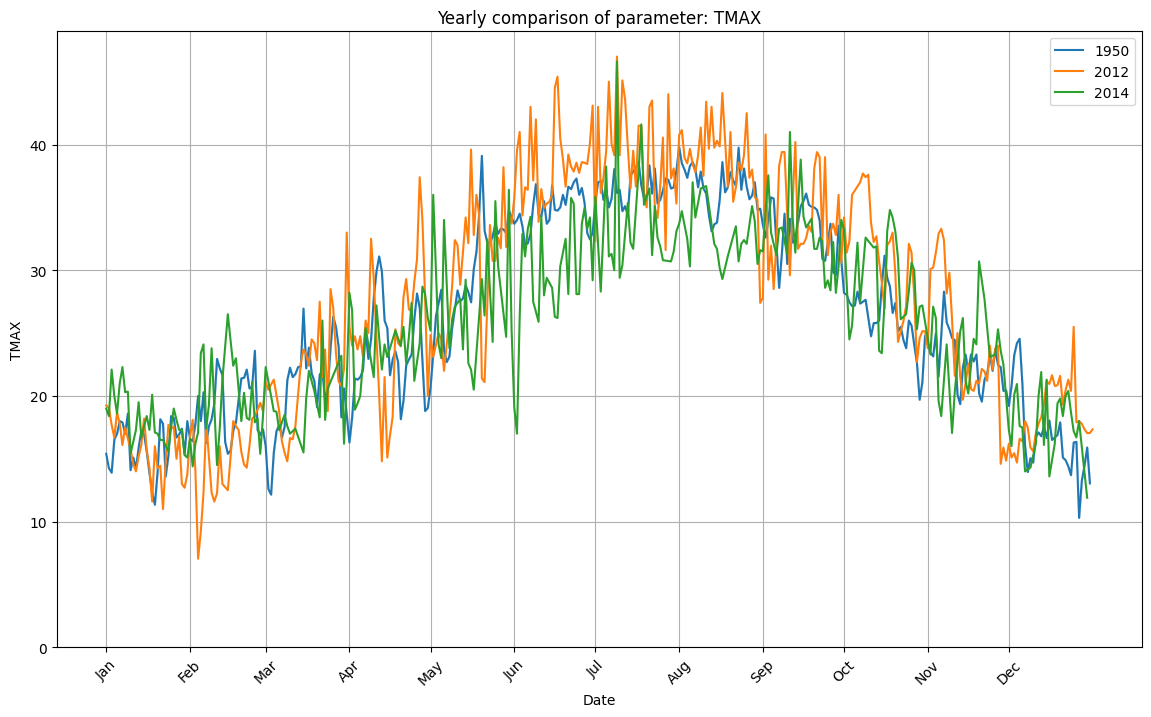

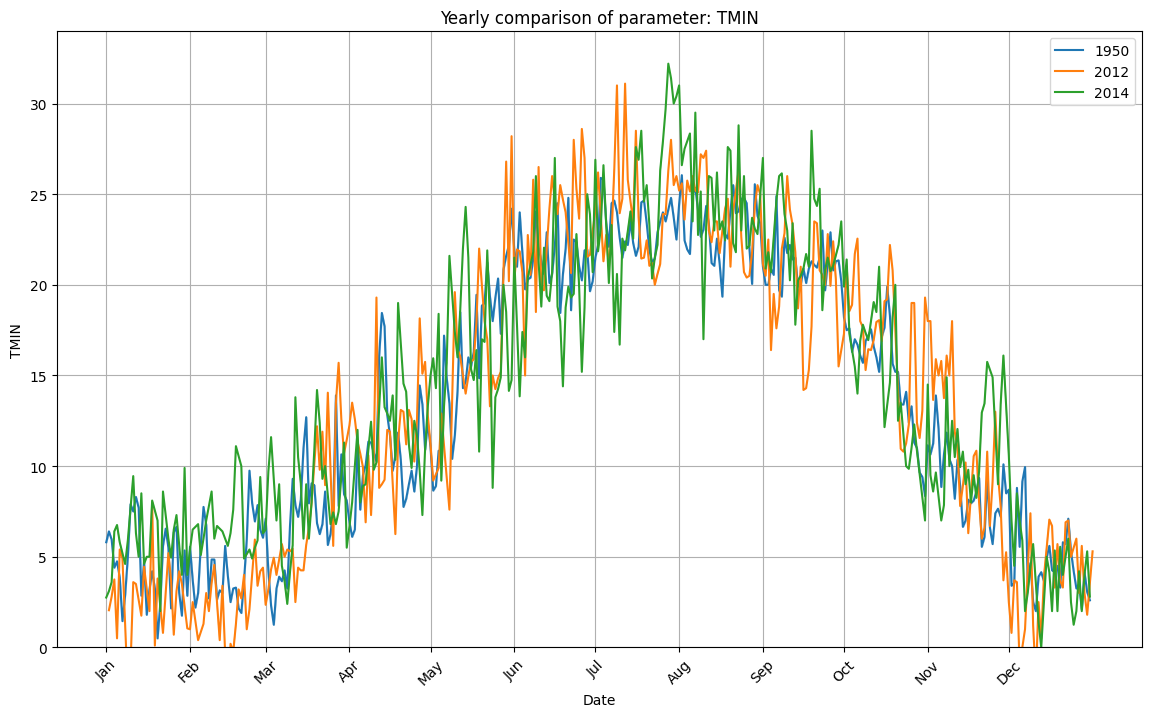

In [64]:
start_date = "1950-01-01"
end_date = "2014-12-31"
parameters = ["TMAX", "TMIN"]
stations = ["AG000060390", "AG000060590"]
columns = ["stationcode", "datelabel", "value", "param"]

def create_linepplot_between_dates(start_date, end_date, stations, parameters, columns = ["stationcode", "datelabel", "value", "param"]):
    tmp = get_data_between_dates(start_date, end_date, parameters, stations, columns)

    # Convert datelabel to datetime format
    tmp["datelabel"] = pd.to_datetime(tmp["datelabel"])
    
    start_year = start_date[:4]
    end_year = end_date[:4]

    for parameter in parameters:
        plt.figure(figsize=(14, 8)) 

        if start_year == end_year & check_year(year):
            df_per_year = tmp[(tmp["datelabel"].dt.year == int(start_year)) & (tmp["param"] == parameter)].copy()

            sns.lineplot(x="datelabel", y="value", style=start_year, data=df_per_year, errorbar=("ci", 1))

            plt.title(f"{start_year} - {parameter}")
            
        else: 
            years_to_plot = np.arange(int(start_year), int(end_year)+1, 1)

            filtered_years = [year for year in years_to_plot if check_year(year)]

            for year in filtered_years:
                df_per_year = tmp[(tmp["datelabel"].dt.year == year) & (tmp["param"] == parameter)]
                df_per_year.loc[:, "day"] = df_per_year.loc[:, "datelabel"].dt.strftime("%m-%d")

                sns.lineplot(x="day", y="value", style=year, data=df_per_year, errorbar=("ci", 1))

                unique_months = df_per_year["day"].str[:2].unique()
                month_labels = [f"{i:02d}-01" for i in range(1, 13)]
                plt.xticks(ticks=month_labels, labels=pd.to_datetime(month_labels, format="%m-%d").strftime("%b"))
                
        plt.title(f"Yearly comparison of parameter: {parameter}")
        plt.xlabel("Date")
        plt.ylabel(f"{parameter}")
        plt.ylim(0, None) 
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

def create_linepplot_years(years, stations, parameters, columns = ["stationcode", "datelabel", "value", "param"]):
    tmp = get_data_yearly(years, parameters, stations, columns)

    # Convert datelabel to datetime format
    tmp["datelabel"] = pd.to_datetime(tmp["datelabel"])

    for parameter in parameters:
        plt.figure(figsize=(14, 8)) 

        filtered_years = [year for year in years if check_year(year)]

        for year in filtered_years:
            df_per_year = tmp[(tmp["datelabel"].dt.year == year) & (tmp["param"] == parameter)]
            df_per_year = df_per_year.copy()
            # df_per_year.loc[:, "day"] = df_per_year["datelabel"].dt.strftime("%m-%d") 
            df_per_year.loc[:, "day"] = df_per_year.loc[:, "datelabel"].dt.strftime("%m-%d")

            sns.lineplot(x="day", y="value", style=year, data=df_per_year, errorbar=("ci", 1))

            unique_months = df_per_year["day"].str[:2].unique()
            month_labels = [f"{i:02d}-01" for i in range(1, 13)]
            plt.xticks(ticks=month_labels, labels=pd.to_datetime(month_labels, format="%m-%d").strftime("%b"))
                
        plt.title(f"Yearly comparison of parameter: {parameter}")
        plt.xlabel("Date")
        plt.ylabel(f"{parameter}")
        plt.ylim(0, None) 
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

# create_linepplot_between_dates(start_date, end_date, stations, parameters)
create_linepplot_years([1950, 2012, 2014], stations, parameters)

### TASK 2: Get Data of a month

In [56]:
def get_month_data(year, month, parameters, stations, columns):
    """
    Retrieves data from the SQL database.

    :return: 
    """
    # connect to database
    connection, cursor = connect_to_db(dbname, dbuser, dbpassword, host, port)
    
    try:
        table_name = f'Climate{year}'

        stations_sql_list = ",".join([f"'{station}'" for station in stations])
        parameters_sql_list = ",".join([f"'{parameter}'" for parameter in parameters])

        # Construct the COUNT query using psycopg2.sql
        command = sql.SQL('''
                SELECT {columns} 
                FROM {table}
                WHERE stationcode IN ({stations}) AND 
                        param IN ({parameters}) AND
                          date_part('month', datelabel) = {month}
                ORDER BY datelabel                
        ''').format(
            columns=sql.SQL(', ').join(map(sql.Identifier, columns)),
            table=sql.Identifier(table_name),
            stations=sql.SQL(stations_sql_list),
            parameters=sql.SQL(parameters_sql_list),
            month=sql.SQL(str(month))
        )

        if debug_messages:
            print(command.as_string(cursor.connection))
        
        # Execute the SELECT query
        cursor.execute(command)
        result = cursor.fetchall()

        data = pd.DataFrame(result, columns=columns)
            
        # Print the result specifications
        if debug_messages:
            print(f"The requested query returned {len(data)} results.")

        return data

    except Exception as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()

    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

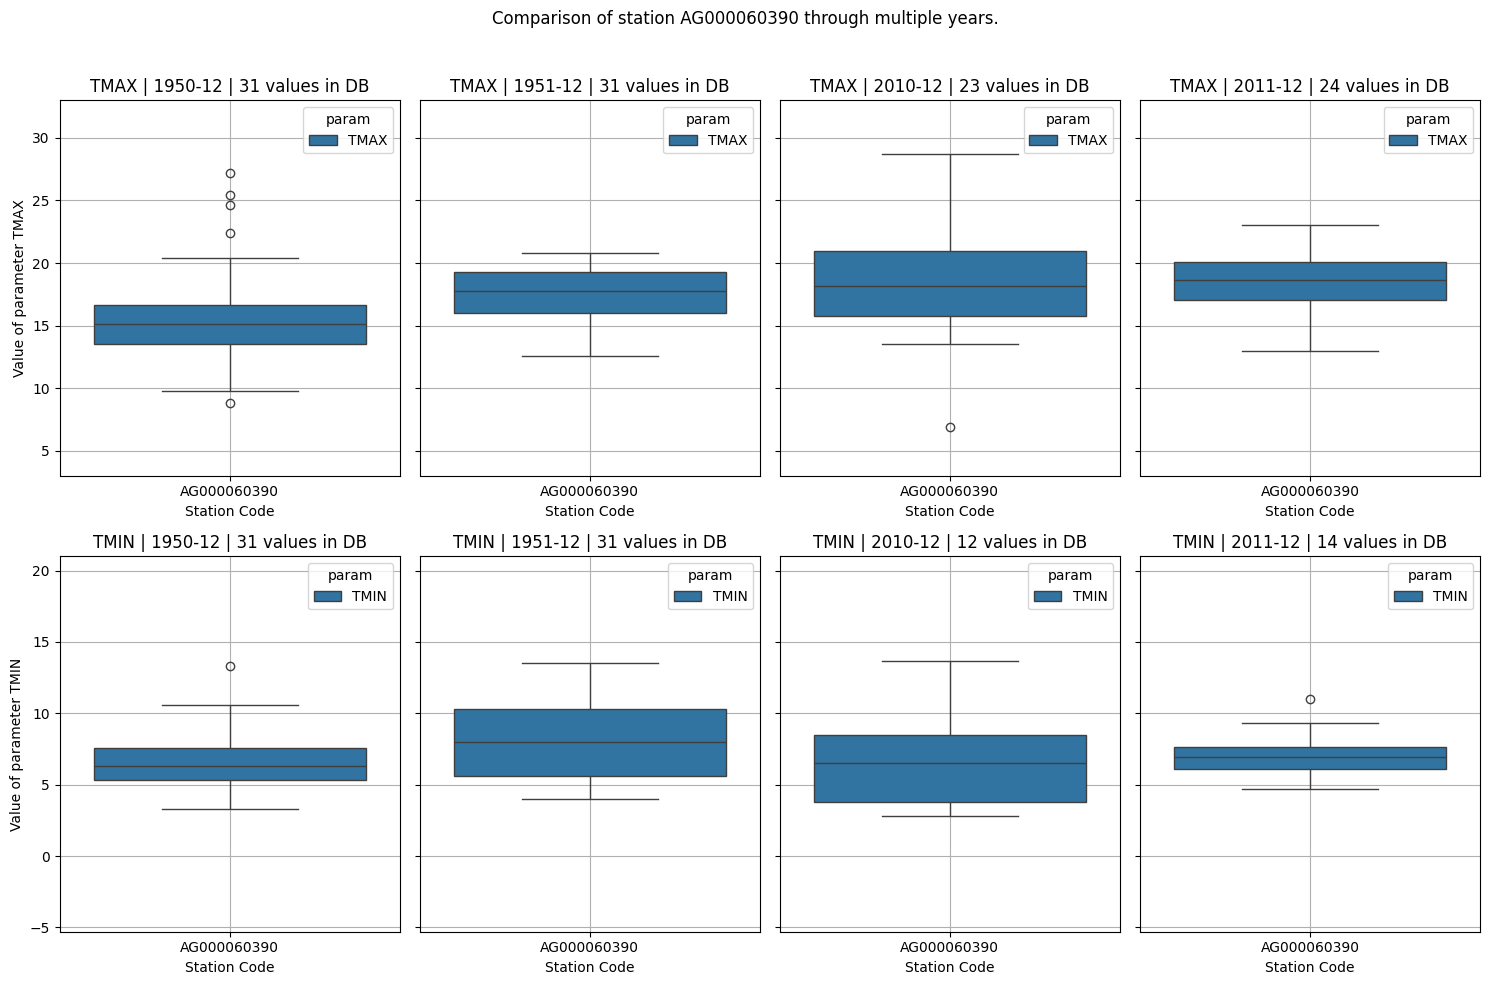

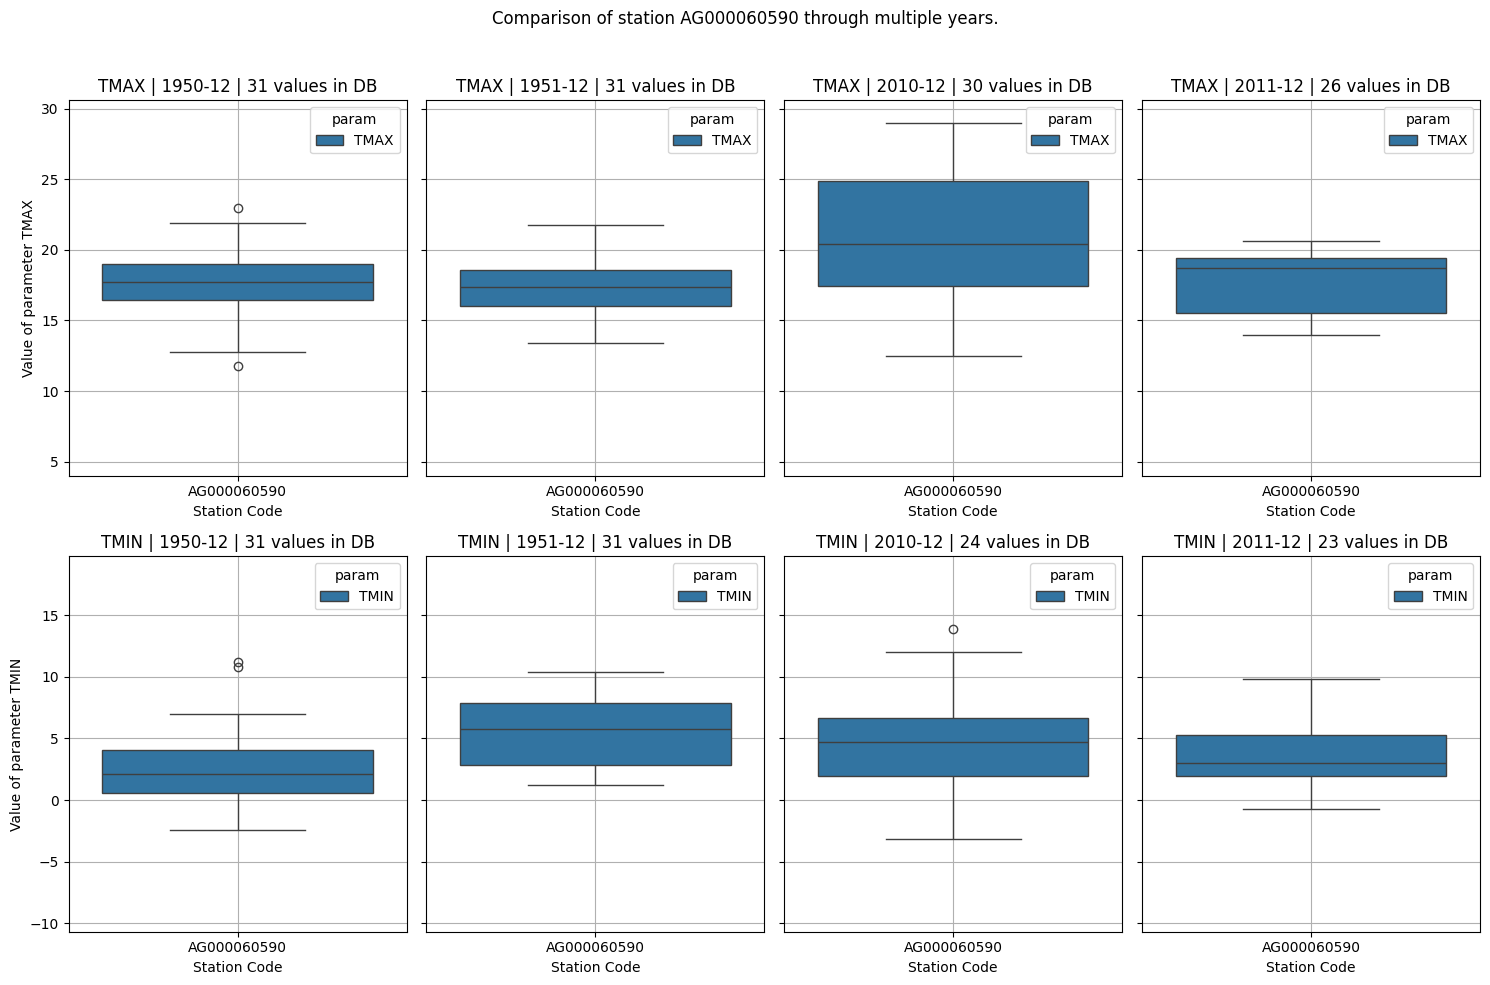

In [59]:
# year = 1950
month = 12
years = [1950, 1951, 2010, 2011]

parameters = ["TMAX", "TMIN"]
stations = ["AG000060390", "AG000060590"]

columns = ["stationcode", "datelabel", "value", "param"]


def create_boxplot_monthly_comparison(years, month, stations, parameters, columns = ["stationcode", "datelabel", "value", "param"]):
    for station in stations:
        fig, axes = plt.subplots(len(parameters), len(years), figsize=(15, 10), sharey="row")
        
        if len(parameters) == 1:
            axes = np.array([axes])

        for i, parameter in enumerate(parameters):
            for j, year in enumerate(years):
                ax = axes[i, j]

                df_get = get_month_data(year, month, parameters=[parameter], stations=[station], columns=columns)

                if not df_get.empty:
                    sns.boxplot(x="stationcode", y="value", data=df_get, ax=ax, hue="param", dodge=True)

                    # Set plot labels and title
                    ax.set_title(f"{parameter} | {year}-{month} | {len(df_get)} values in DB")
                    ax.set_xlabel("Station Code")
                    ax.set_ylabel(f"Value of parameter {parameter}")
                    ax.set_ylim(df_get["value"].min()-10, df_get["value"].max()+10)
                    ax.grid()

        plt.suptitle(f"Comparison of station {station} through multiple years.")
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.96])  

        # Show plot
        plt.show()

create_boxplot_monthly_comparison(years, month, stations, parameters)

### TASK 3: Geographic Plot of stations

In [58]:
plt.figure(figsize=(12, 8))
plt.scatter(station_data['longitude'], station_data['latitude'], c=station_data['elevation'], cmap='viridis', marker='o')
plt.colorbar(label='Elevation (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of Stations')
plt.show()

NameError: name 'station_data' is not defined

<Figure size 1200x800 with 0 Axes>

### Notes

Empty DataFrame
Columns: []
Index: []


C:\Users\Fabi\AppData\Local\Temp\ipykernel_25032\3895072870.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


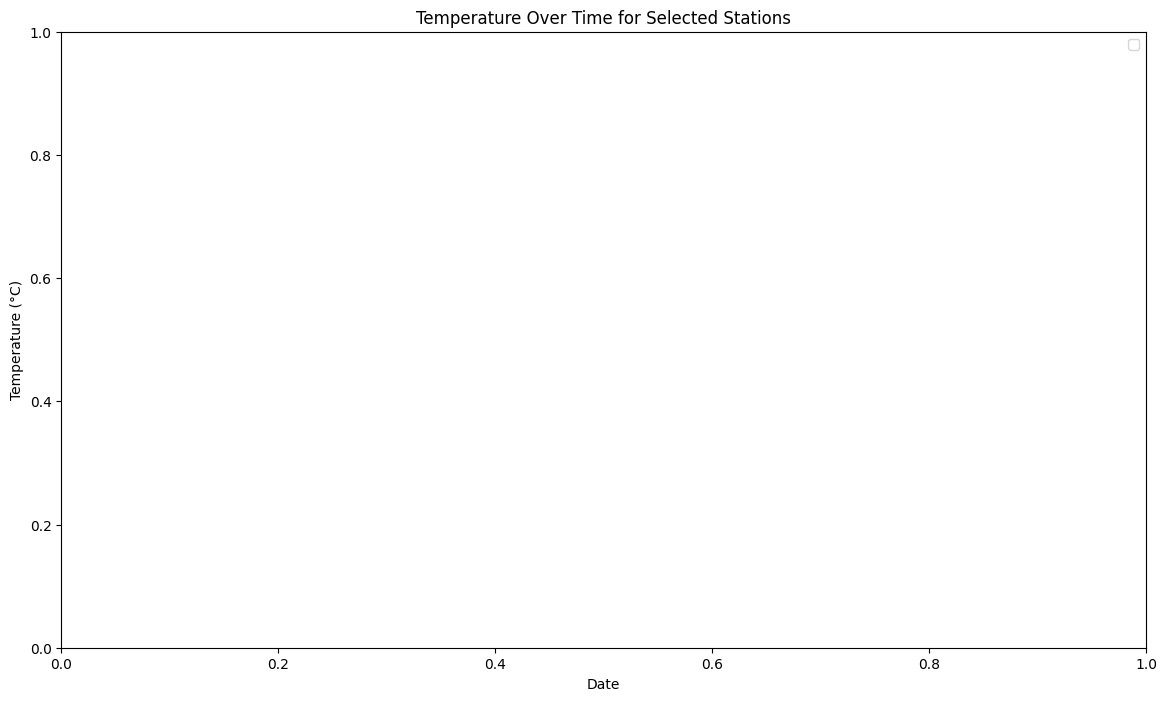

KeyError: 1951

In [ ]:

for year in years: 
    df = pd.DataFrame(climate_data[year], columns=["id", "stationcode", "datelabel", "param", "value"])
    
    df['datelabel'] = pd.to_datetime(df['datelabel'], format='%Y%m%d')
    
    # Convert data_value to numeric
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    # Select a few stations for the plot
    stations_to_plot = ['ACW00011604', 'AG000060390', 'AG000060590']

    # Filter data for selected stations
    filtered_data = df[df['stationcode'].isin(stations_to_plot)]

    # Pivot data for easier plotting
    pivoted_data = filtered_data.pivot_table(index='datelabel', columns=['stationcode', 'param'], values='value')

    print(pivoted_data.head())

    # Plotting
    plt.figure(figsize=(14, 8))
    for station in stations_to_plot:
        if (station, 'TMAX') in pivoted_data.columns:
            plt.plot(pivoted_data.index, pivoted_data[(station, 'TMAX')], label=f'{station} TMAX')
        # if (station, 'TMIN') in pivoted_data.columns:
        #     plt.plot(pivoted_data.index, pivoted_data[(station, 'TMIN')], label=f'{station} TMIN')

    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title('Temperature Over Time for Selected Stations')
    plt.legend()
    plt.show()
# from datetime import datetime
colors = sns.color_palette("husl", len(years))

# Create a plot for each station
for station in stations_to_plot:
    plt.figure(figsize=(14, 8))

    # Plot data for each year with different colors
    for year, color in zip(years, colors):
        df = pd.DataFrame(climate_data[year], columns=["id", "stationcode", "datelabel", "param", "value"])
        df['datelabel'] = pd.to_datetime(df['datelabel'], format='%Y%m%d')
        df['value'] = pd.to_numeric(df['value'], errors='coerce')

        # Filter data for the current station and year
        station_data = df[(df['stationcode'] == station) & (df['datelabel'].dt.year == year)]

        if not station_data.empty:
            plt.plot(station_data['datelabel'].dt.strftime('%m-%d'), station_data['value'], label=f'{year}', color=color)

    # Set plot labels and title
    plt.xlabel('Day of Year (MM-DD)')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Over Time for Station {station} (10 Years)')
    plt.legend(title='Year')

    # Ensure the x-axis covers the entire year from January to December
    plt.xticks(rotation=45)
    plt.show()
# climate_data = get_table_data(years, ["id", "datelabel", "param", "value"], "param in ('TMXAX', 'TMIN')" )
# station_data = get_station_table_data(["id", "latitude", "longitude", "elevation", "name"])
print(climate_data[0])
# Convert date to datetime format
climate_data['datelabel'] = pd.to_datetime(climate_data['datelabel'], format='%Y%m%d')


# Convert data_value to numeric
climate_data['value'] = pd.to_numeric(climate_data['value'], errors='coerce')

# Select a few stations for the plot
stations_to_plot = ['ACW00011604', 'AG000060390', 'AG000060590']

# Filter data for selected stations
filtered_data = climate_data[climate_data['id'].isin(stations_to_plot)]

# Pivot data for easier plotting
pivoted_data = filtered_data.pivot_table(index='datelabel', columns=['id', 'param'], values='value')

# Plotting
plt.figure(figsize=(14, 8))
for station in stations_to_plot:
    if ('TMAX', station) in pivoted_data.columns:
        plt.plot(pivoted_data.index, pivoted_data[('TMAX', station)], label=f'{station} TMAX')
    if ('TMIN', station) in pivoted_data.columns:
        plt.plot(pivoted_data.index, pivoted_data[('TMIN', station)], label=f'{station} TMIN')

plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time for Selected Stations')
plt.legend()
plt.show()